## CX4240 project

## Classification of Acute Lymphoblastic Leukemia (ALL) in Blood Cell Images Using Machine Learning

# Classification: Convolutional Neural Network

 Run it on Goolge Colab

In [1]:
import numpy as np
np.random.seed(1000)
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# For CNN model creation
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.utils import to_categorical

import os
import cv2
from PIL import Image



Using TensorFlow backend.


In [2]:
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize
import psutil
import humanize
import os, time
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]

def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

def worker():
  if SHOW_GPU_USAGE_TIME == 0:
    return;
  while True:
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    time.sleep(SHOW_GPU_USAGE_TIME)

import threading
t = threading.Thread(target=worker, name='Monitor')
t.start()

ModuleNotFoundError: No module named 'humanize'

In [21]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive

In [0]:
# There are two ways to load data
# One way is to upload data from your GoogleDrive. Have the data file as zip
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




In [5]:
# Another way is to upload it from your local machine. 
# Choose your zip file. It may take 30min to an hour.
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data.zip


In [0]:
import zipfile
import io
# unzip the data
data = zipfile.ZipFile(io.BytesIO(uploaded['Data.zip']), 'r')
data.extractall()

In [0]:
data.printdir()

File Name                                             Modified             Size
Data/CNMC_readme.pdf                           2019-06-19 19:06:46        82011
Data/C-NMC_test_prelim_phase_data/             2019-07-16 14:22:50            0
Data/C-NMC_test_prelim_phase_data/.DS_Store    2019-06-19 15:25:04        10244
Data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data/ 2019-07-16 14:23:26            0
Data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data/1.bmp 2019-06-19 15:25:04       608538
Data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data/10.bmp 2019-06-19 15:25:04       608538
Data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data/100.bmp 2019-06-19 15:25:04       608538
Data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data/1000.bmp 2019-06-19 15:25:04       608538
Data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data/1001.bmp 2019-06-19 15:25:04       608538
Data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data/1

In [7]:
img_path_all = 'Data/C-NMC_training_data/fold_' 
img_path_hem = 'Data/C-NMC_training_data/fold_'

SIZE = 225
train_data = []
label_train = []
for i in range(3):
    for file in glob.glob(img_path_all + str(i) + '/all' + '/*bmp'):
        image = cv2.imread(file)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        train_data.append(np.array(image))
        label_train.append(1)
n_ALL = len(train_data)
## Load hem images
for i in range(3):
    for file in glob.glob(img_path_hem + str(i) + '/hem' + '/*bmp'):
        image = cv2.imread(file)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        train_data.append(np.array(image))
        label_train.append(0)
n_hem = len(train_data) - n_ALL
print(np.shape(train_data))



(10661, 225, 225, 3)


In [8]:
#load test data
img_path_test = "Data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data/" + "*.bmp"

SIZE = 225
test_temp,label_test, test_ids = [],[],[]
start = len(img_path_test) - 5
for file in glob.glob(img_path_test):
    test_ids.append(file[start: -4])
    image = cv2.imread(file)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((SIZE, SIZE))
    test_temp.append(np.array(image))
       
label_test_df = pd.read_csv('Data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data_labels.csv')
label_test = label_test_df['labels'].as_matrix()
n_test = len(test_temp)
#resort test_data
test_ids = np.asarray(test_ids, dtype=int)
test_data= np.zeros(np.shape(test_temp), dtype=np.uint8)
# put the test data in order
test_data[test_ids-1] = test_temp
print(np.shape(test_data))
n_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(1867, 225, 225, 3)


1867

Text(0.5, 0.98, 'Test Cells')

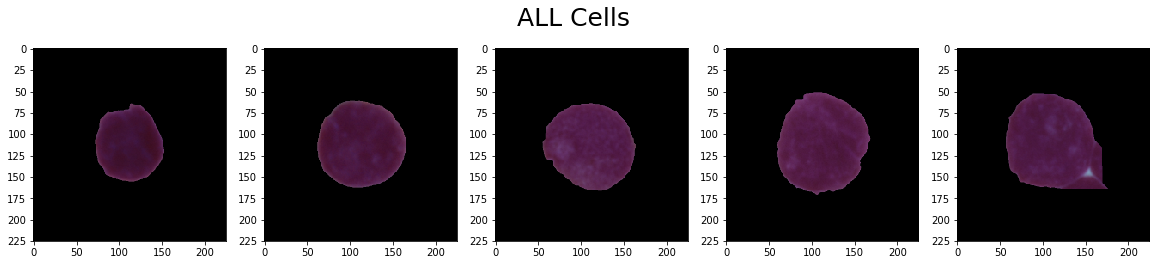

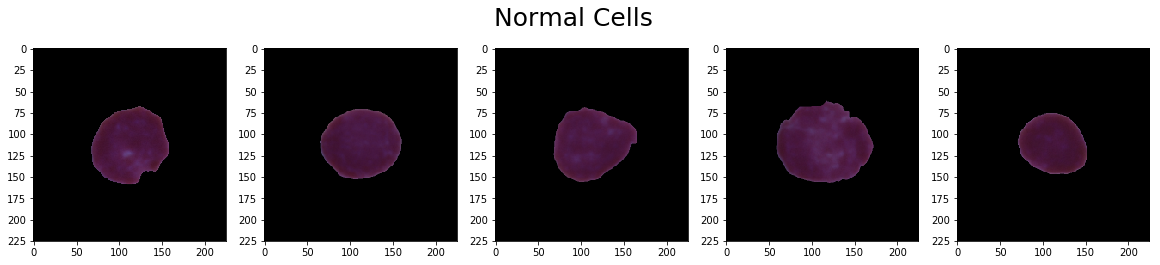

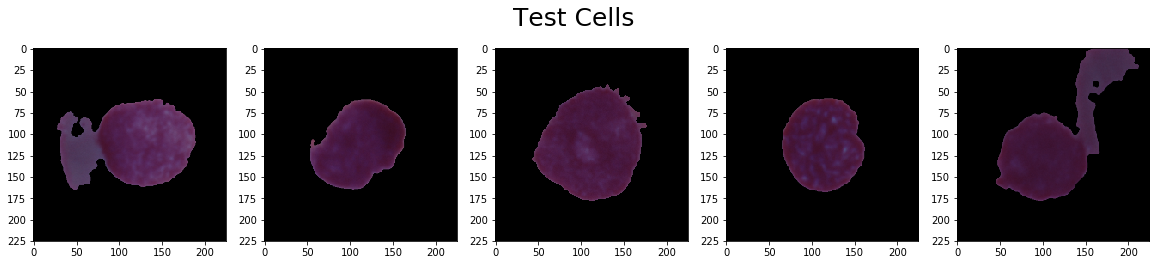

In [0]:
plt.figure(figsize = (20, 4))
for i, j in enumerate(np.random.randint(n_ALL, size = 5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_data[j])
plt.suptitle('ALL Cells', fontsize=25)

plt.figure(figsize = (20, 4))
for i, j in enumerate(np.random.randint(n_hem, size = 5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_data[n_ALL+j])
plt.suptitle('Normal Cells', fontsize=25)

plt.figure(figsize = (20, 4))
for i, j  in enumerate(np.random.randint(n_test, size = 5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_data[j])   
plt.suptitle('Test Cells', fontsize=25)

In [0]:
# remove Data.zip to free up the space
!rm Data.zip

In [10]:


### Structure of CNN model
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (SIZE, SIZE, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Flatten())
classifier.add(Dense(activation = 'relu', units=512))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Dense(activation = 'relu', units=256))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Dense(activation = 'sigmoid', units=2))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(classifier.summary())




W0722 07:32:22.461863 140138082101120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 07:32:22.477978 140138082101120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 07:32:22.497478 140138082101120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 07:32:22.565159 140138082101120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0722 07:32:22.584243 140138082101120 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 111, 111, 32)      128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 394272)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               201867776 
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
__________

In [0]:
# Split training data
X_train, X_test, y_train, y_test = train_test_split(train_data, 
                                                    to_categorical(np.array(label_train)), 
                                                    test_size = 0.2, 
                                                    random_state = 1000)   
    

In [12]:

history = classifier.fit(np.array(X_train), 
                         y_train, 
                         batch_size = SIZE, 
                         verbose = 2, 
                         epochs = 10, 
                         validation_split = 0.1,
                         shuffle = True)
                         

W0722 07:32:24.311793 140138082101120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7675 samples, validate on 853 samples
Epoch 1/10
 - 338s - loss: 0.5386 - acc: 0.7722 - val_loss: 0.5127 - val_acc: 0.7902
Epoch 2/10
 - 328s - loss: 0.4284 - acc: 0.8051 - val_loss: 0.4108 - val_acc: 0.8277
Epoch 3/10
 - 329s - loss: 0.3768 - acc: 0.8300 - val_loss: 0.4625 - val_acc: 0.7632
Epoch 4/10
 - 327s - loss: 0.2967 - acc: 0.8661 - val_loss: 1.4039 - val_acc: 0.3740
Epoch 5/10
 - 326s - loss: 0.2205 - acc: 0.9053 - val_loss: 1.3512 - val_acc: 0.4185
Epoch 6/10
 - 327s - loss: 0.1884 - acc: 0.9169 - val_loss: 0.6977 - val_acc: 0.7140
Epoch 7/10
 - 325s - loss: 0.1465 - acc: 0.9406 - val_loss: 0.8665 - val_acc: 0.7186
Epoch 8/10
 - 326s - loss: 0.0960 - acc: 0.9596 - val_loss: 0.9776 - val_acc: 0.6518
Epoch 9/10
 - 326s - loss: 0.0797 - acc: 0.9689 - val_loss: 2.1736 - val_acc: 0.4982
Epoch 10/10
 - 325s - loss: 0.0653 - acc: 0.9746 - val_loss: 0.6681 - val_acc: 0.7679


In [13]:
print("Train_Accuracy: {:.2f}%".format(classifier.evaluate(np.array(X_test), np.array(y_test))[1]*100))
print("Test_Accuracy: {:.2f}%".format(classifier.evaluate(np.array(test_data), np.array(label_test))[1]*100))

2133/2133 [==============================] - 29s 14ms/step
Train_Accuracy: 76.37%


ValueError: ignored